In [1]:
# import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.cluster import DBSCAN
import string
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

In [2]:
# loading the dataset
train=pd.read_csv("quora.csv")

In [3]:
train.head()

,question,Unnamed: 1
0,What is the step by step guide to invest in sh...,NaN
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,NaN
2,How can I increase the speed of my internet co...,NaN
3,Why am I mentally very lonely? How can I solve...,NaN
4,"Which one dissolve in water quikly sugar, salt...",NaN


In [4]:
train["question"].head()

0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
Name: question, dtype: object

In [5]:
#convert each question to a list of string
data = pd.Series(train["question"].tolist()).astype(str)

In [6]:
data = data[:1000]

In [7]:
data[:1]

0    What is the step by step guide to invest in sh...
dtype: object

## Text Preprocessing

In [8]:
nlp = spacy.load('en_core_web_sm')
stop_list = ['best','different',"won\'t", "couldn\'t", "mustn\'t", "didn\'t", "dtype object"]
for word in stop_list:
    spacy.lang.en.stop_words.STOP_WORDS.add(word)
    nlp.vocab[word].is_stop = True

In [9]:
def normalize(data):
    """Run all the functions for preprocessing in a pipeline"""
    clean_data = re.sub(re.compile('<.*?>'), '', data)
    cleaned_list = [ unicodedata.normalize('NFKD', word.text).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in  nlp(clean_data)]
    cleaned_list = " ".join(cleaned_list)
    cleaned_list = [word.text.rstrip('0123456789').lower() for word in nlp(cleaned_list) if word.pos_  in ['NOUN','PROPN', 'VERB'] and not word.is_digit and not word.is_punct and not word.is_stop ]
    return cleaned_list

In [11]:
# Preprocess the text data
normalized_data = []
for i, batch in data.groupby(np.arange(len(data)) // 10):
    for batch_data in batch:
        normalized_data.append(normalize(batch_data))

In [12]:
# Data after prerocessing
normalized_data 

[['step', 'step', 'guide', 'invest', 'share', 'market', 'india'],
 ['story', 'kohinoor', 'koh', 'noor', 'diamond'],
 ['increase', 'speed', 'internet', 'connection', 'vpn'],
 ['solve'],
 ['dissolve', 'water', 'sugar', 'salt', 'methane', 'carbon', 'oxide'],
 ['astrology', 'capricorn', 'sun', 'cap', 'moon', 'cap', 'rising'],
 ['buy', 'tiago'],
 ['geologist'],
 ['use'],
 ['motorola', 'company', 'hack', 'charter', 'motorolla', 'dcx'],
 ['method', 'find', 'separation', 'slits', 'fresnel', 'biprism'],
 ['read', 'find', 'youtube', 'comments'],
 ['physics', 'learn'],
 ['experience'],
 ['laws',
  'change',
  'status',
  'student',
  'visa',
  'card',
  'compare',
  'immigration',
  'laws',
  'canada'],
 ['trump', 'presidency', 'mean', 'master', 'students', 'f', 'visa'],
 ['manipulation', 'mean'],
 ['girls', 'want', 'friends', 'guy', 'reject'],
 ['quora', 'users', 'posting', 'questions', 'answered', 'google'],
 ['marketing', 'institution', 'banglore'],
 ['rockets', 'look'],
 ['causing'],
 ['quest

In [68]:
# function to form sentences from token
# function to form sentences from token
sentence = []
sentences = []


def token_2_sentence(normalized_data):
    """Join the tokens in each list with space to form a sentence"""
    for i in normalized_data:
      sentence = " ".join(i)
      sentences.append(sentence)
      sentence = [] 
    return sentences
    
sentences_list = token_2_sentence(normalized_data)

In [69]:
sentences_list[:10]

['step step guide invest share market india',
 'story kohinoor koh noor diamond',
 'increase speed internet connection vpn',
 'solve',
 'dissolve water sugar salt methane carbon oxide',
 'astrology capricorn sun cap moon cap rising',
 'buy tiago',
 'geologist',
 'use',
 'motorola company hack charter motorolla dcx']

## DBSCAN with TFIDF

In [70]:
# TFIDF and DBSCAN
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

class tfidf_dbscan:
    
    def calc_tfidf(self, sentences_list,min_df, max_df ):
        """ Function to calculate tfidf score """
        self.sentences_list = sentences_list
        # Find tfidf score for every sentence in the dataset
        vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df = min_df, max_df = max_df, decode_error = "ignore") # considers upto 5 ngrams
        X = vectorizer.fit_transform(sentences_list).toarray() # toarray converts sparse matrix to dense array
        print("Number of features",len(vectorizer.get_feature_names())) # length of features
        print("Features",vectorizer.get_feature_names()) # display the feature words  which can be changed by adjusting the value of min_df and max_df
        return vectorizer

    def transform_doc(self,data, vectorizer ):
        X = np.zeros(len(vectorizer.get_feature_names())).reshape(1,len(vectorizer.get_feature_names()))
        self.data = data
        for doc in data:
            x = vectorizer.transform([doc]).toarray()
            X = np.concatenate((X,x))
        return X
    
    def dbscan(self, X, eps, min_samples):
        """ Function to form clusters using  DBSCAN algorithm"""
#         eps =  # how close points should be to each other to be considered a part of a cluster 
#         min_samples = # the minimum number of points to form a dense region  
        dbscan = DBSCAN( eps=eps, min_samples=min_samples )
        X = pca.fit_transform(X)
        dbscan_model = dbscan.fit(X)
        return dbscan_model
        
    def form_cluster(self,dbscan_model):
        """ Function to form clusters """
        self.dbscan_model = dbscan_model
        core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)
        core_samples_mask[dbscan_model.core_sample_indices_] = True
        labels1 = dbscan_model.labels_
        n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0) # Number of clusters in labels
        print("Cluster Labels",labels1)
        print()
        print("Number of clusters",n_clusters_) # number of clusters
        return labels1

    def display_clusters(self, labels1):
        """Function to display clsuters"""
        self.labels1= labels1
        clusters1 = {} # a dictionary for different cluster 
        for c, i in enumerate(labels1):
            if i == -1:
                continue
            elif i in clusters1:
                clusters1[i].append( data[c])
            else:
                clusters1[i] = [data[c]]
        for c in clusters1: # print the different clusters
            print("Cluster No."+" "+str(c)+" "+str(clusters1[c]))
            print()


    def main(self, sentences_list):
        """Main function : find finds tfidf score then forms clusters using DBSCAN algorithm """
        self.sentences_list = sentences_list
        vectorizer = self.calc_tfidf(sentences_list, 0.005,0.98)
        X = self.transform_doc(data,vectorizer)
        print(X.shape)
        X= X[1:]
        dbscan_model = self.dbscan(X,0.0001,3)
        labels = self.form_cluster(dbscan_model)
        self.display_clusters(labels)
        
    

In [71]:
# Display the features, Cluster Labels, Number of Clusters and different Clusters
td = tfidf_dbscan()
td.main(sentences_list)

Number of features 118
Features ['account', 'android', 'answer', 'book', 'business', 'buy', 'career', 'cause', 'causes', 'change', 'class', 'clinton', 'college', 'come', 'compare', 'computer', 'cost', 'courses', 'day', 'death', 'difference', 'differences', 'eat', 'election', 'email', 'energy', 'engineering', 'exist', 'experience', 'facebook', 'feel', 'find', 'friend', 'friends', 'gain', 'girl', 'google', 'got', 'government', 'guy', 'happen', 'hate', 'help', 'hillary', 'improve', 'increase', 'india', 'internet', 'job', 'know', 'language', 'learn', 'learning', 'life', 'like', 'look', 'looking', 'lose', 'love', 'math', 'mean', 'modi', 'money', 'months', 'movies', 'notes', 'number', 'pakistan', 'people', 'person', 'phone', 'place', 'play', 'pm', 'porn', 'prepare', 'presidency', 'programming', 'programming language', 'quality', 'question', 'questions', 'quora', 'recover', 'relationship', 'review', 'run', 'salary', 'science', 'series', 'sex', 'song', 'start', 'stop', 'students', 'system', 't

Number of features 118
Features ['account', 'android', 'answer', 'book', 'business', 'buy', 'career', 'cause', 'causes', 'change', 'class', 'clinton', 'college', 'come', 'compare', 'computer', 'cost', 'courses', 'day', 'death', 'difference', 'differences', 'eat', 'election', 'email', 'energy', 'engineering', 'exist', 'experience', 'facebook', 'feel', 'find', 'friend', 'friends', 'gain', 'girl', 'google', 'got', 'government', 'guy', 'happen', 'hate', 'help', 'hillary', 'improve', 'increase', 'india', 'internet', 'job', 'know', 'language', 'learn', 'learning', 'life', 'like', 'look', 'looking', 'lose', 'love', 'math', 'mean', 'modi', 'money', 'months', 'movies', 'notes', 'number', 'pakistan', 'people', 'person', 'phone', 'place', 'play', 'pm', 'porn', 'prepare', 'presidency', 'programming', 'programming language', 'quality', 'question', 'questions', 'quora', 'recover', 'relationship', 'review', 'run', 'salary', 'science', 'series', 'sex', 'song', 'start', 'stop', 'students', 'system', 't

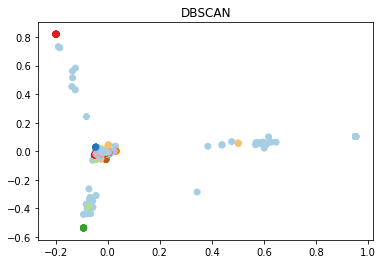

In [72]:
from sklearn.decomposition import PCA

def plot_dbscan(X , eps, min_samples):
    """Function to plot clusters"""
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    print(result.shape)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(result)
    y_pred = db.fit_predict(result)
    plt.scatter(result[:,0], result[:,1],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")
    
plot_dbscan( tfidf_dbscan().transform_doc(data,tfidf_dbscan().calc_tfidf(sentences_list, 5,300)),0.001, 3)